<a href="https://colab.research.google.com/github/mariaorsus/CAPTCHA/blob/master/%D0%9F%D1%80%D0%B0%D0%B2%D0%B8%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A3%D1%87%D0%B5%D0%B1%D0%BD%D0%BE%D0%B5_%D1%81%D0%BE%D1%80%D0%B5%D0%B2%D0%BD%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

In [ ]:
import numpy as np
images = np.load('drive/MyDrive/images.npy')
labels = np.load('drive/MyDrive/labels.npy')
images_sub = np.load('drive/MyDrive/images_sub.npy')
print(f'images: {images.shape} of type {images.dtype}')
print(f'labels: {labels.shape} of type {labels.dtype}')
print(f'images_sub: {images_sub.shape} of type {images_sub.dtype}')

num_classes = 26 #количество классов
img_shape = (48, 48, 3) #размер изображений

images: (20000, 48, 48, 3) of type uint8
labels: (20000,) of type int64
images_sub: (50000, 48, 48, 3) of type uint8


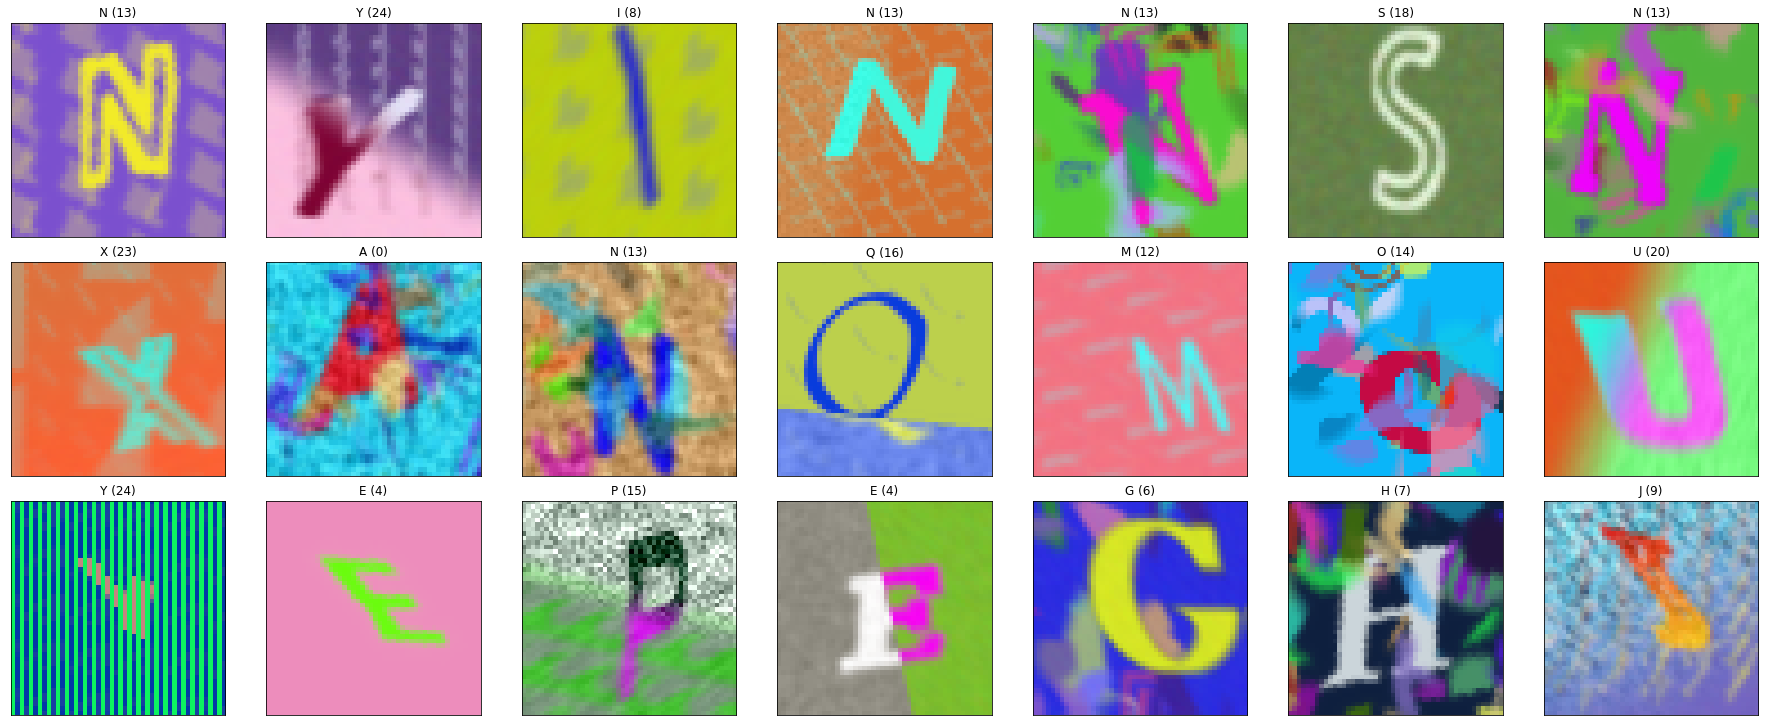

In [ ]:
import matplotlib.pyplot as plt

def label_to_letter(label):
    return chr(ord('A') + label)

def show_symbols(images, labels = None, columns = 10, **kwargs):
    if labels is None: labels = [None] * len(images)
    rows = (len(images) - 1) // columns + 1
    fig = plt.figure(figsize = (25, (1.8 * 13 / columns) * rows))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = fig.add_subplot(rows, columns, i + 1)
        imshow_kwargs = {'vmin': 0, 'vmax': 255}
        imshow_kwargs.update(kwargs)
        ax.imshow(img, **imshow_kwargs)
        if label is not None: ax.set_title(label)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    fig.tight_layout(pad = 0.5)
    plt.show()

display_count = 7*3
show_symbols(
    images[:display_count],
    labels = [f'{label_to_letter(x)} ({x})' for x in labels[:display_count]],
    columns = 7
)

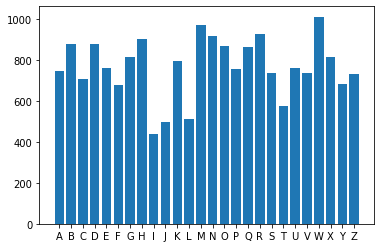

Вероятность случайного угадывания: 0.0385


In [ ]:
import string
plt.bar(x = list(string.ascii_uppercase), height = np.bincount(labels));
plt.show()

print(f'Вероятность случайного угадывания: {1/num_classes:.4f}')

In [ ]:
images_normalized = images / 255
images_sub_normalized = images_sub / 255

In [ ]:
import keras
from IPython.display import clear_output

In [ ]:
model = keras.Sequential([
    keras.Input(shape = img_shape),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = keras.optimizers.Adam(1e-4),
    metrics = 'accuracy'
)

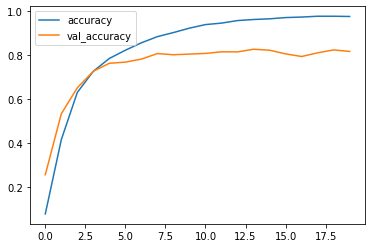

In [ ]:
for epoch in range(20):
    history = model.fit(
        images_normalized, labels, verbose = 1,
        batch_size = 8,
        validation_split = 0.15,
        epochs = 1,
        callbacks = ([model.history] if epoch > 0 else None)
    )
    clear_output(wait = True)
    plt.plot(history.history['accuracy'], label = 'accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.legend()
    plt.show()

In [ ]:
predictions = model.predict(images_sub_normalized)
print(predictions.shape)

(50000, 26)


In [ ]:
predictions = predictions.argmax(axis = 1)
print(predictions.shape)
print(predictions[:10]) # посмотрим первые 10 предсказаний

(50000,)
[19 11 14 12 10  7  5 17 23 22]


In [ ]:
import pandas as pd
submission = pd.DataFrame()
submission['Id'] = list(range(len(predictions)))
submission['Category'] = predictions
submission.to_csv('submission9.csv', index = False)